Lab 01: Introduction to Deep Learning Models, and their Training, Fine-Tuning, and Evaluation

- basic functionality of PyTorch, focusing on key operations such as data loading, data transformations, and using GPUs for acceleration

In [20]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

Tensors
- Tensors in PyTorch Tensors are the primary data structure in PyTorch. They are similar to NumPy arrays but have added functionality that supports GPU acceleration and automatic differentiation (autograd)

Automatic differentiation in PyTorch is a key feature for calculating gradients automatically in tensors

In [3]:
a = torch.tensor([ 1.0 , 2.0 , 3.0 ])
b = torch.tensor([ 4.0 , 5.0 , 6.0 ])

c = a + b     ### addition element-wise
print(c) 

print(f"the tensor shape is {c.shape}")
print(f"the tensor type is {c.dtype}")

tensor([5., 7., 9.])
the tensor shape is torch.Size([3])
the tensor type is torch.float32


float32 (single precision) data type. NumPy, instead, defaults to float64 (double precision)

In [4]:
from timeit import timeit

mat_size = 1000

M1_64 = torch.randn(mat_size, mat_size, dtype=torch.float64)   ### here we have a tensor of double precision float64
M2_64 = torch.randn(mat_size, mat_size, dtype=torch.float64)

M1_32 = torch.randn(mat_size, mat_size)                        ### here we have a tensor of single precision float32
M2_32 = torch.randn(mat_size, mat_size)

t64 = timeit(lambda: M1_64 @ M2_64, number=100)                # we use the lambda function tu compute 100 times matrices product      
t32 = timeit(lambda: M1_32 @ M2_32, number=100)

print(f"Time for matrix multiplication (float64): {t64:.4f}s")
print(f"Time for matrix multiplication (float32): {t32:.4f}s")

Time for matrix multiplication (float64): 1.8918s
Time for matrix multiplication (float32): 0.9468s


if is strictly needed you can change the type of array 

In [6]:
c = c.to(torch.float64) # or,
print(type(c)) 
c = c.double()

<class 'torch.Tensor'>


Exercise 1: A simple neural network

-univariate linear model is one of the most basic forms of machine learning models and is defined by the equation y = wx + b

Model Definition: SimpleLinearModel
The SimpleLinearModel class is a subclass of nn.Module, which is the base class for all neural network modules in PyTorch

The SimpleLinearModel class is structured as follows:

__init__(self, input_size, output_size):

This is the constructor method where the linear layer is defined. The input_size and output_size parameters specify the dimensions of the input and output features, respectively. In this exercise, both the input and output sizes are set to 1, indicating a single feature input and a single prediction output.
forward(self, x):

This method defines the forward pass of the model, where the input x is passed through the linear layer. The forward pass computes the output by applying the linear transformation described above

In [7]:
# Define a simple linear model
class SimpleLinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

In [9]:
# Initialize the model, loss function, and optimizer
model = SimpleLinearModel(1, 1)
print(model)

SimpleLinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


Using torch.device for GPU Acceleration

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"The device is set to: {device}")

The device is set to: cpu


Finally, note that these tensors have the requires_grad attribute set to True. This attribute is used by PyTorch to determine which tensors should have their gradients computed during the backward pass (i.e., which tensors are learnable parameters). This is used by PyTorch to keep track of the computational graph.

In [11]:
print("Weight", model.linear.weight)
print("Bias", model.linear.bias)

Weight Parameter containing:
tensor([[-0.2717]], requires_grad=True)
Bias Parameter containing:
tensor([-0.3678], requires_grad=True)


Criterion and Optimizer

-The criterion, also known as the loss function, is a measure of how well the model's predictions match the actual target values. During training, the loss function evaluates the difference between the predicted outputs and the true labels, quantifying the error of the model. The goal of training is to minimize this error, thereby improving the model's accuracy.

-Cross Entropy: Used for multi-class classification problems, like our CIFAR-10 and CIFAR-100 tasks. We typically use PyTorch's CrossEntropyLoss, which takes as input the predicted logits (not the probabilities, so unnormalized probabilities that have not been passed through a softmax) is applied) and the ground truths. Alternatively, we could combine LogSoftmax and NLLLoss (Negative Log Likelihood Loss) together, or applying the softmax ourselves and then using a Negative Log Likelihood function. However, for numerical reasons, we generally prefer using the CrossEntropyLoss class directly.

-Mean Squared Error (MSE): Typically used for regression tasks, where the model predicts continuous values.

Optimizer
The optimizer is an algorithm or method used to adjust the model's weights to minimize the loss function. It updates the model parameters (weights and biases) based on the gradients computed during backpropagation. The optimizer aims to find the optimal set of parameters that reduce the loss, improving the model’s performance on the training data.

Some common optimizers include:

-Stochastic Gradient Descent (SGD): A basic optimizer that updates the model parameters using a small, randomly selected subset of data (mini-batch) instead of the entire dataset. It’s useful for handling large datasets and reducing computational cost.

-Adam: A more advanced optimizer that combines the benefits of two other extensions of SGD, Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). It adjusts the learning rate for each parameter dynamically, making it well-suited for complex tasks with sparse gradients.

In [15]:
# Create a dataset (for simplicity, we use a small synthetic dataset)
# X is the input features, y is the target labels

n_pts = 2048
# TODO: Generate a random dataset containing n_pts samples
# Notes:
# - The input features X should be a tensor of shape (n_pts, 1)
# - you can generate the X's randomly (e.g. using torch.rand to sample uniformly from [0,1], or torch.randn to sample from a normal distribution)
# - The target labels y should be a linear function of X with some noise added, y = w*x + b + gaussian noise

# In this solution we are using normally distributed inputs. It is 
# well-known that 0-centered inputs help speed up the learning process.
# You can try using uniformly distributed inputs, or adding an offset to
# all points and see the difference in learning speed (weight/bias
# plots shown afterwards)
X = torch.randn(n_pts, 1)
y = 5 * X + 3 + 0.1 * torch.randn(n_pts, 1) # adding gaussian noise

# Create DataLoader
dataset = TensorDataset(X, y)
trainloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [16]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Training Loop 


In [17]:
# Training loop
num_epochs = 50

# TODO: keep track of the loss computed at each step, 
# the current value for the weight of the linear layer,
# and the current bias value for the linear layer.
# Note: store the values in the lists losses, weights, biases
losses = []
weights = []
biases = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss, weight, and bias
        losses.append(loss.item())
        weights.append(model.linear.weight.item())
        biases.append(model.linear.bias.item())

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/50], Loss: 36.7363
Epoch [2/50], Loss: 25.8294
Epoch [3/50], Loss: 18.1630
Epoch [4/50], Loss: 12.7764
Epoch [5/50], Loss: 8.9873
Epoch [6/50], Loss: 6.3233
Epoch [7/50], Loss: 4.4506
Epoch [8/50], Loss: 3.1339
Epoch [9/50], Loss: 2.2077
Epoch [10/50], Loss: 1.5564
Epoch [11/50], Loss: 1.0983
Epoch [12/50], Loss: 0.7757
Epoch [13/50], Loss: 0.5490
Epoch [14/50], Loss: 0.3895
Epoch [15/50], Loss: 0.2772
Epoch [16/50], Loss: 0.1982
Epoch [17/50], Loss: 0.1426
Epoch [18/50], Loss: 0.1035
Epoch [19/50], Loss: 0.0759
Epoch [20/50], Loss: 0.0565
Epoch [21/50], Loss: 0.0428
Epoch [22/50], Loss: 0.0332
Epoch [23/50], Loss: 0.0264
Epoch [24/50], Loss: 0.0217
Epoch [25/50], Loss: 0.0183
Epoch [26/50], Loss: 0.0159
Epoch [27/50], Loss: 0.0143
Epoch [28/50], Loss: 0.0131
Epoch [29/50], Loss: 0.0123
Epoch [30/50], Loss: 0.0117
Epoch [31/50], Loss: 0.0113
Epoch [32/50], Loss: 0.0110
Epoch [33/50], Loss: 0.0108
Epoch [34/50], Loss: 0.0106
Epoch [35/50], Loss: 0.0105
Epoch [36/50], Loss: 0.01

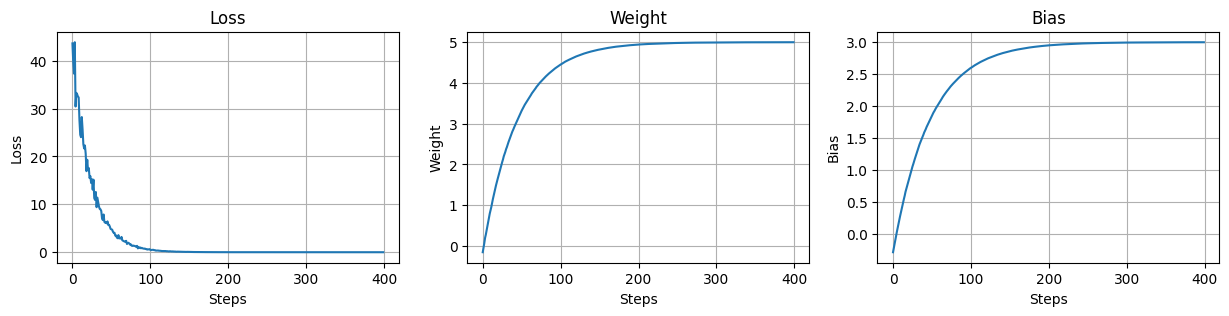

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(losses)
ax[0].set_title("Loss")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(weights)
ax[1].set_title("Weight")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Weight")
ax[1].grid()

ax[2].plot(biases)
ax[2].set_title("Bias")
ax[2].set_xlabel("Steps")
ax[2].set_ylabel("Bias")
ax[2].grid()

In [24]:
# Inspecting the learned weights and biases
weights = model.linear.weight.data
biases = model.linear.bias.data

print(f'Learned weights: {weights}')
print(f'Learned biases: {biases}')

Learned weights: tensor([[5.0002]])
Learned biases: tensor([3.0019])


Exercise 2: First Model Training

you will explore the concept of transfer learning by training a model on the CIFAR-10 dataset and then adapting it to a different dataset, CIFAR-100

This approach is especially useful in fields like Natural Language Processing (NLP), where training a model from scratch requires immense computational resources and vast amounts of data. Instead, pre-trained models are often used as backbones, and only the final classification head is fine-tuned for specific tasks.

The CIFAR-10 and CIFAR-100 datasets are both standard datasets in computer vision. They contain 32x32 color images, but while CIFAR-10 has 10 classes, CIFAR-100 has 100 classes, making it a more challenging task.

In this exercise, you will:

Train a model from scratch on CIFAR-10 and evaluate its performance.

Compare the performance on CIFAR-10 of two models:

-The model trained from scratch from point 1.

-A model pre-trained on ImageNet (another dataset of images) and then fine-tuned on CIFAR-10.

-Modify the classification head to adapt the model for CIFAR-100.

Loading the CIFAR-10 Dataset and Creating a DataLoader

We apply a simple transformation to the images, which start out as PIL images (PIL is a famous Python libraries that handles images), 
to convert them into PyTorch tensors. We do this using the transforms.ToTensor() transformation.

In [ ]:
dataset_dir = "~/data" # Change this to the directory where you want to download the dataset
# Download CIFAR-10 dataset and apply the transformations
trainset = torchvision.datasets.CIFAR10(
    root=dataset_dir, train=True, download=True, transform=transforms.ToTensor()
)

# Create a DataLoader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)

# Get a batch of data to verify that everything is working
# dataiter = iter(trainloader)
images, labels = next(iter(trainloader)) #dataiter.next()

print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")
print(f"Possible classes: {', '.join(trainset.classes)}")

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(8,8, figsize=(8,8))
plt.rcParams.update({'axes.titlesize': 'small'})
plt.tight_layout()
# remove vertical space
plt.subplots_adjust(hspace=0.25, wspace=0.1)

for i in range(8):
    for j in range(8):
        # note that we need to change the order of the dimensions.
        # Torch prepare the images to be (C, H, W),
        # But matplotlib expects (H, W, C)
        # (H = height of the image, W = width of the image, C = number of color channels)
        ax[i,j].imshow(images[i*8 + j].permute(1,2,0))
        ax[i,j].set_title(trainset.classes[labels[i*8 + j]])
        ax[i,j].axis('off')

Data Transformations

Transformations involve modifying the inputs (e.g., images) in the dataset to make the model more robust to variations in input data and prevent overfitting

It's important to note that the transformations applied to the training data differ from those applied to the validation data

Training Transformations

Training transformations are designed to augment the dataset, effectively increasing the diversity of the input images seen by the model during training. This helps improve the model's ability to generalize to unseen data. Common training transformations include:

Random Crop: Randomly crops a given portion of an image. This helps the model become invariant to the position of objects within the image.

Random Horizontal Flip: Randomly flips an image horizontally. This technique ensures that the model learns features regardless of the orientation of objects.

Normalization: Adjusts the pixel values to have a mean of 0 and a standard deviation of 1. Normalization helps speed up training and can lead to better model performance.




Validation Transformations
Validation transformations, on the other hand, are intended to provide a consistent evaluation of model performance by ensuring the input data is in a standardized format. Typically, validation transformations include:

Normalization: Similar to training, normalization is applied to adjust the pixel values to have a mean of 0 and a standard deviation of 1. This ensures that the distribution of values in the validation samples is the same one used in the training samples (since the model already learned to expect that distribution of values).

So, the key difference is that training transformations often include random augmentations (such as cropping and flipping) to introduce variability, whereas validation transformations are more standardized and deterministic to provide a stable basis for evaluating the model's performance